# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns

In [4]:
data1 = pd.read_csv('/datasets/geo_data_0.csv')
data2 = pd.read_csv('/datasets/geo_data_1.csv')
data3 = pd.read_csv('/datasets/geo_data_2.csv')

In [5]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


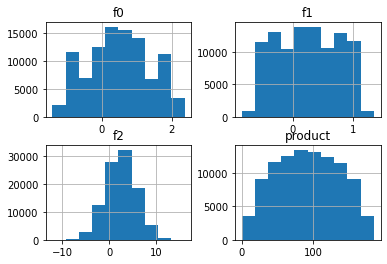

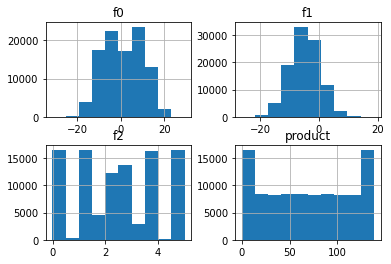

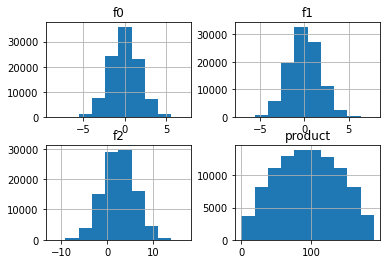

In [6]:
data1.hist();
data2.hist();
data3.hist();

в регионе с индексом 1 распределение значений отличается от стальных регионов

## Обучение и проверка модели

Создам функцию при вызове которой к дата фрейму будут пременяны разбиение на признаки, тренировочные и валидационные выборки и сразу выведет метрики точности и средний запас по всем скважинам в районе

In [7]:
# функция для расчета запаса предсказанного сырья

def predicted_raw_material(data, info=False):
    features = data.drop(['id','product'], axis=1)
    target = data['product']
    features_train,  features_valid, target_train, target_valid = train_test_split(features,target,test_size=0.25,random_state=12345)
    model = LinearRegression()
    model.fit(features_train,target_train)
    predicted = model.predict(features_valid)
    
    # функция выведет информацию если попросят
    if info:
        rmse = mean_squared_error(target_valid, predicted, squared=False)
        print('score:', model.score(features_valid, target_valid))
        print('rmse:', rmse)
        print('средний запас предсказанного сырья по скважинам в регионе:', predicted.mean())

    return pd.Series(predicted, index=target_valid.index) , target_valid  # функция вернет Серии предсказаний и правильных ответов



In [8]:
data_all_region = [] #  сохраним серии предсказаний и таргетов в список

for i,j in enumerate([data1,data2,data3], start=1):
    print('на данных региона',i)
    data_all_region.append(predicted_raw_material(j, True))
    print()

на данных региона 1
score: 0.27994321524487786
rmse: 37.5794217150813
средний запас предсказанного сырья по скважинам в регионе: 92.59256778438035

на данных региона 2
score: 0.9996233978805127
rmse: 0.893099286775617
средний запас предсказанного сырья по скважинам в регионе: 68.728546895446

на данных региона 3
score: 0.20524758386040443
rmse: 40.02970873393434
средний запас предсказанного сырья по скважинам в регионе: 94.96504596800489



на второй регионе модель показала очень высокую точность  - так как один из признаков очень сильно коррелируюет с целевым значением, которое имеет равномерное распределение

## Подготовка к расчёту прибыли

Один баррель сырья приносит 450 рублей дохода. 
Объём product указан в тысячах баррелей. Доход с каждой единицы продукта составляет 450 тыс. рублей.

Бюджет на разработку скважин в регионе — 10 млрд рублей, это 22222.22 единицы product. 

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки. Получается в среднем на скважину (одну из 200) требуеся не менее 111.11 product(тысяч бареллей)

Если отобрать 200 лучших скважин и посчитаем сумму их product в каждом регионе и вычесть минимальный объем безубыточности и умножить на цену producta -  получаем формулу расчета прибыли в регионе

In [30]:
def profit(data,probab):
    best_count = 200  # количество скважин под разработку
    min_prod = 22222   # минимальное количество продукта для безубытка на регион
    price_barel = 450000  # цена за 1000 барелей
    
    # отберем лучшие предказанные значения,
    best_probab_index = probab.sort_values(ascending=False).head(best_count).index
    
    # print(len(data[best_probab_index]))
    # возьмем реальные данные соответсвующих скважин проссумируем и вычтем минимальное значение безубыточности
    result = (data[best_probab_index].sum() - min_prod) * price_barel
    return result

посчитаем прибыль по имеющимся данным

In [27]:
for i,j in enumerate([data1,data2,data3],start=1):
    print(f'прибыль разработки в регионе {i}: { (profit(j["product"],j["product"]).round(0)/10**9).round(3) } млрд рублей')

200
прибыль разработки в регионе 1: 6.635 млрд рублей
200
прибыль разработки в регионе 2: 2.415 млрд рублей
200
прибыль разработки в регионе 3: 7.06 млрд рублей


Мы посчитали прибыль на реальных данных,

## Расчёт прибыли и рисков 

### Расчет прибыли на предсказаниях

воспользуемся функцией profit - рассчитаем прибыль для предсказанного объёма сырья.

In [34]:
# в цикле вызовем функцию расчета прибыли в которую данные будут поступать из функции предсказания 

# напомню что данные лежат в  data_all_region под индексами [номер региона][0-предсказания/1-таргеты]

for i,j in enumerate(data_all_region, start=1):
    #predict_data = predicted_raw_material(j)
    print(f'прибыль предсказанной разработки в регионе {i}: {( profit(j[1],j[0]) / 10 ** 9 ).round(3)} млрд рублей')

прибыль предсказанной разработки в регионе 1: 3.321 млрд рублей
прибыль предсказанной разработки в регионе 2: 2.415 млрд рублей
прибыль предсказанной разработки в регионе 3: 2.71 млрд рублей


модель показала супер точность на втором регионе, но там данные видимо подобраны таким образом ...

### Риски для каждого региона:

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

Смоделируем процесс отбора случайных точек из региона и для них посчитаем прибыль

In [15]:
state = np.random.RandomState(12345)

средняя выручка по региону 1: 0.392 млрд рублей
95%-й доверительный интервал от -0.125 до 0.864 млрд рублей
риск убытков: 0.068 %  

средняя выручка по региону 2: 0.459 млрд рублей
95%-й доверительный интервал от 0.098 до 0.866 млрд рублей
риск убытков: 0.008 %  

средняя выручка по региону 3: 0.388 млрд рублей
95%-й доверительный интервал от -0.109 до 0.899 млрд рублей
риск убытков: 0.066 %  



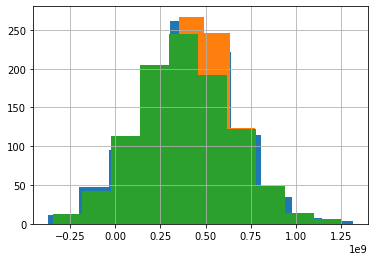

In [31]:
for k,j in enumerate(data_all_region, start=1):
    values = [] 
    # отберем 1000 раз по 500 значений
    for i in range(1000):
        # 500 раз отберем случайно  значения из целевых реальных значений
        target_subsample = j[1].sample(n=500, replace=True, random_state=state)
        # и выберем соответсвующие им предсказанные значения
        probab_subsample = j[0][target_subsample.index]
        
        target_subsample = target_subsample.reset_index(drop=True)
        probab_subsample = probab_subsample.reset_index(drop=True)
        
        # расчитаем прибыль на этих выборках
        result = profit(target_subsample, probab_subsample)
        # запишем значения
        values.append(result)

    values = pd.Series(values) # Серия со значениями прибыли которую на генерировали бутстрепом из предсказанных данных
    values.hist()
    
    print(f'средняя выручка по региону {k}: {(values.mean() / 10 ** 9 ).round(3)} млрд рублей')
    
    # отбросим по 2.5 процента от количества значений с хвостов для получения 95% доверительного интервала
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    print(f'95%-й доверительный интервал от {(lower / 10 ** 9 ).round(3)} до {(upper / 10 ** 9 ).round(3)} млрд рублей')
    
    # риск убытков - доля значений  меньше 0 в полученном values 
    print(f'риск убытков: {(values < 0).mean()} %  ') # {len(values[values<0]) / len(values)}
    print()

новые выводы

Модель показала что лучше всего для добычи подходит первый  регион -  средняя прибыль больше чем в остальных регионах. но данные получены наиболее точно для второго региона. С помощью метода бутстреп смоделировали процесс отбора 500 точек и получили распределение прибылей - показала что лушим решением будет добыча во втором регионе. Риск убытков - минимален на втором регионе.